Planning payments on the Lightning Network one needs to decide on which routes of channel one wishes to send onions of various amounts. This is also known as deciding on a payment flow. For the case of the current protocol [the optimal solution can be found by solving a suitably modelled minimum cost flow problem](https://arxiv.org/abs/2107.05322). However in practice the minimum cost flow approach yields several problems: 

1. The base fee and non uniform probability distributions for the liquidity distribution make the problem non linear and [hard to compute](https://lists.linuxfoundation.org/pipermail/lightning-dev/2021-August/003203.html)
2. The disection of the flow into paths (actual onions with amounts) is arbitrary
3. While a flow optimized for reliability is optimally reliable the uncertainty about the remote's channels liquidity will still trigger failures of sent payments.

Thus with a minor protocol change (c.f. [stuckless / cancable payments](https://bitcoinops.org/en/topics/redundant-overpayments/)) one could plan a payment with redundancy and in particular plan the payment such that the expected number of sats to be arrived at the recipient corresponds to the invoice amount. In [this repository we describe research explaining that the payment flow maximizing the expected delivered value does not correspond to the solution of the priviously used minimum cost flow](https://github.com/renepickhardt/Maximum-Expected-Value-Flows-For-Redundant-Overpayments) (note in particular [this simple counter example](https://github.com/renepickhardt/Maximum-Expected-Value-Flows-For-Redundant-Overpayments/blob/main/img/counterExample.png))  

While the optimal solution to maximize the expected value is to send 1 satoshi onions (which is impractical in practise) we note in this research that several reasonable approximations are possible. In particular create a series of augmenting paths on which one allocates as many sats as one wishes to send in order to maximize the expected value. The advantage of this new approach is that one does not have to use the [information content](https://en.wikipedia.org/wiki/Information_content) (also known as `uncertainty cost` or `negative log probabilities`) as a cost function for minimum cost flow or shortest path computation. Instead after having selected a path for augmentation based on what ever cost metric is desirable one predicts a suitable allocation of sats for this path. This allocation could for example be chosen so that the onion has a certain success probability or such that the expected value of delivered sats is being maximized. Both approaches depend on the choice of the probabilistic model for the uncertainty about the liquidity in a channel which is why we start modeling vaious Distributions.

## Main Contributions

### 1. Section: Probabilistic Models 

We invastigate 4 different probability density functions and their respective cummulative distribution functions to model the uncertainty of liquidity (also given certainty that `min_liquidity` or `max_liquidity` exists using conditional probabilities and baysian learning) within payment channels on the lightning network. They are the: 

* Uniform Distribution
* Linearlly Drained Channel Model
* Exponentially Drained Channel Model
* Bimodal Distribution

### 2. Section: Expectation Value Maximizing Allocation for Payment paths

For a `Path` of channels `c_1,...,c_n` we use the corresponding probabilistic priors `P_1,...,P_n` to compute the `expected value function` as:

```
ev(amt) = amt * P_1(X_1 > amt | min_1 < X_1 < max_1) * ... * P_n(X_n > amt | min_n < X_n < max_n)
```

Generaly speaking the `expected value function` is non linear and needs to be maximized. In practise we are often interested in the first non negative local maximum as this also minimizes the liquidity requirements. This also shows (see below) that the bimodal prior is hard to use in practise. We suggest to use a unimodal (not uniform) prior and predict the drain of the channel correctly from outside features. 

As our functions have mathmatically a rather simple structure we use an interval based heuristic to numerically find it's maxima which in all our thousands of studied test cases that we looked at never failed (besides the expected approximation error from the stepsize)


## Future work
1. Properly investigate how the augmentation of paths with maximum expected value differs to the approach of negative bernoulli trials where all ammounts on the paths are allocated in a way so that all onions have the same success probability (the approach with the [negative bernoulli trials is vaguely described here](https://arxiv.org/abs/2103.08576) and [a bit more concretely here](https://github.com/renepickhardt/pickhardtpayments/pull/36)).
2. Deciding how to assamble the packages in particular if the amounts into which the payment is split are not of uniform size (This problem exist with all non unisize redundant payment splitters).
3. **Find collaborators who want to test with mainnet data which of the models best fits the reality**

## Funding and Acknowledgements

This research result is funded through [NTNU](https://www.ntnu.no) and [BitMEX](https://blog.bitmex.com/bitmex-2021-open-source-developer-grants/) as well as generous donations from the Bitcoin community via https://donate.ln.rene-pickhardt.de and via recurring donations at https://www.patreon.com/renepickhardt. If you want to learn why independent research and development for Bitcoin and the Lightning Network is important I kindly refer you to: https://ln.rene-pickhardt.de/ of course I will be grateful if you consider my work of importance and decide to support.

## Copyright and License
This work was created by Rene Pickhardt and is openly licensed under the [Apache License](https://www.apache.org/licenses/LICENSE-2.0)

In [1]:
from math import log2 as log
import matplotlib.pyplot as plt
from typing import List
from matplotlib.patches import Polygon
import numpy as np
import time

# 1 - Probabilistic Channel Models

## 1.0. Base Class (mostly boiler plate code)

Every channel needs to bring their method how to compute a `pdf` (probability density function) and a `cdf` (cummulative distribution function) which is just the integral of the `pdf`. 

Given the `cdf` every Channl can compute the `conditional_success_probability` as the ratio between the area under the `pdf`s given with the help of the `cdf`s.

In [2]:
from abc import ABC, abstractmethod

#TODO: adding normalization of non 100 sats channel (internally transform)
class Channel(ABC):
    """
    the abstract base class is a blue print for all probabilistic channels that we investigate
    
    """
    def __init__(self, capacity:int, min_liquidity:int =None, max_liquidity:int =None):
        if capacity <=0:
            raise Exception("capacity must not be negative or zero {} given".fomat(capacity))
        if min_liquidity is None:
            min_liquidity = 0
        if max_liquidity is None:
            max_liquidity = capacity

        self.capacity = capacity
        self.max_liquidity = max_liquidity
        self.min_liquidity = min_liquidity
    
    @property
    def max_liquidity(self):
        return self._max_liquidity

    @max_liquidity.setter
    def max_liquidity(self, value: int):
        if value < 0 or value > self.capacity:
            raise Exception("max_liquidity must be in channel range [0,{}] but {} was given".format(self.capacity, value))
        self._max_liquidity = value
        # TODO: could also just fix max_liquidity in such moments
        #if value < self.min_liquidity:
        #    raise Exception("max_liquidity ({}) must be larger than min_liquidity ({})".format(value, self.min_liquidity))

        
    @property
    def min_liquidity(self):
        return self._min_liquidity

    @min_liquidity.setter
    def min_liquidity(self, value: int):
        if value < 0 or value > self.capacity:
            raise Exception("min_liquidity must be in channel range [0,{}] but {} was given".format(self.capacity, value))
        self._min_liquidity = value
        # TODO: could also just fix max_liquidity in such moments
        #if value > self.max_liquidity:
        #    raise Exception("min_liquidity ({}) must be smaller than max_liquidity ({})".format(value, self.max_liquidity))

    def __str__(self):
        return "channel [0,{}] with uncertainty between [{},{}]".format(self.capacity,self.min_liquidity,self.max_liquidity)

    def conditional_success_probability(self, a):
        if a <= self.min_liquidity:
            return 1.0
        if a > self.max_liquidity:
            return 0.0

        numerator = self.cdf(self.max_liquidity+1) - self.cdf(a)
        # TODO: check again why not `0` instead of `min_liquidity` !
        denumerator = self.cdf(self.max_liquidity+1) - self.cdf(self.min_liquidity)
        return numerator/denumerator

    @abstractmethod
    def pdf(self,a):
        pass
        
    @abstractmethod
    def cdf(self,a):
        pass
    
    def plot_conditional_success_probability(self,first=True,last=True):
        x_values = [i*0.01 * self.capacity for i in range(101)]
        #probabilities = [self.conditional_success_probability(i) for i in range(self.capacity+1)]
        probabilities = [self.conditional_success_probability(x) for x in x_values]
        if first:
            plt.figure(figsize=(9,6))
            plt.title("Conditional Success Probability")
        plt.plot(x_values, probabilities,".",label=str(self))
        if last:
            plt.xlabel("percantage of smallest capacity (aka amount to send)")
            plt.ylabel("success probability")
            plt.grid()
            plt.legend()
            plt.show()

    def plot_information_content(self,first=True,last=True):
        x_values = []
        probabilities = []
        for x in [i*0.01 * self.capacity for i in range(101)]:
            p = self.conditional_success_probability(x)
            if p == 0:
                continue
            probabilities.append(-log(p))
            x_values.append(x)
        if first:
            plt.figure(figsize=(9,6))
            plt.title("Information Content of a Payment channel")
        plt.plot(x_values, probabilities,".",label=str(self))
        if last:
            plt.xlabel("percantage of smallest capacity (aka amount to send)")
            plt.ylabel("information content (uncertainty cost)")
            plt.grid()
            plt.legend()
            plt.show()

            
    def plot_pdf(self,first=True,last=True):
        x_values = [i*0.01 * self.capacity for i in range(101) if  i*0.01 * self.capacity > self.min_liquidity]
        probabilities = [self.pdf(x) for x in x_values]
        if first:
            plt.figure(figsize=(9,6))
            plt.title("Probability density functions of Payment Channels")
        plt.plot(x_values, probabilities,".",label=str(self))
        if last:
            plt.xlim(0,self.capacity)
            plt.xlabel("amount = a ")
            plt.ylabel("probability that exactly a sats exist in the channel")
            plt.grid()
            plt.legend()
            plt.show()
        
    def plot_expected_value_curve(self,split_of_min_liquidity=False):
        max_ev = 0
        max_amount = 0
        expected_values = []
        amounts = []
        points = [(self.min_liquidity,0)]
        for i in range(100):
            amt = i*self.capacity*0.01
            ev = 0
            if split_of_min_liquidity:
                if amt < self.min_liquidity:
                    ev = amt
                else:
                    ev = self.min_liquidity + self.conditional_success_probability(amt)*(amt-self.min_liquidity)
            else:
                ev = self.conditional_success_probability(amt)*amt
            amounts.append(amt)
            expected_values.append(ev)
            if ev > max_ev:
                max_amount = amt
                max_ev = ev
            if self.min_liquidity<=amt and amt <= self.max_liquidity:
                points.append((amt,ev))
        points.append((self.max_liquidity,0))

        fig, ax = plt.subplots(figsize=(9,6))
        plt.suptitle("Expected delivered sats on " + str(self))
        if split_of_min_liquidity:
            plt.title("sent min liquidity seperately and remainder in a total of 2 onions")
        else:
            plt.title("sent one atomic onion")
            
        ax.plot(amounts,expected_values,".")
        ax.plot([max_amount,max_amount],[0,max_ev],"k-.",label="allocation for max expected: {}".format(max_amount))
        ax.plot([0,max_amount],[max_ev,max_ev],"k:",label="max expected delivered amount: {:4.2f}".format(max_ev))

        ax.add_patch(Polygon(points,color="grey"))
        plt.xlabel("planned / allocated amount = a ")
        plt.ylabel("expected amount to be delivered on average")
        #plt.ylim(0,25)
        plt.legend()
        plt.grid()
        plt.show()       

## 1.1 - Review of the Uniform Chanel Model

The probability distribution of the uniform channel assumes that every liquidity split between the peers has equal likelyhood. This means for a channel with capacity $cap$ and and amount $amt$ we have

$P(X = amt) = \frac{1}{cap + 1}$

The Successprobability consequently can be described as: 

$P(X >= amt) = \frac{cap + 1 - amt}{cap +1}$

All the conditional probabilities including the way to handle inflight htlcs [have been described extensively in this issue on the LDK repository](https://web.archive.org/web/20230310194340/https://github.com/lightningdevkit/rust-lightning/issues/1170#issuecomment-972396747). 

The main disadvantage of the `uniform model` is that it heavily prefers large channels and does not depend on anything besides capacity. In particular it does not account for drain in channels.

The main advantage is that it is easy to understand and compute and the [`Information Content`](https://en.wikipedia.org/wiki/Information_content) (also known as `Uncertainty Cost` or negative log probabilities) is [known to be convex](https://arxiv.org/abs/2107.05322) which is particularly nice when solvinging minimum cost flow problems

The `cdf` computes as $cdf(amt) = \frac{amt}{cap+1}$


In [3]:
class UniformChannel(Channel):
    def __init__(self,capacity:int, min_liquidity:int =None, max_liquidity:int =None):
        super().__init__(capacity, min_liquidity, max_liquidity)
        
    def __str__(self):
        return "uniform "+ super().__str__()
    
    def pdf(self, a):
        if a < self.min_liquidity:
            return 1.0
        if a > self.max_liquidity:
            return 0.0
        return 1.0/(self.max_liquidity - self.min_liquidity + 1)
    
    def cdf(self, a):
        return float(a)/(self.capacity+1)

Let us look at a channel of capacity `100` for which we know for some reason that it has `35` sats of liquidity available and the other side has `10` sats. Knowing that our peer has `10` sats means that we can have at most `100 - 10 = 90` sats in the channel. 

We can then plot the `Conditional success probbaility` and `Information content` for this channel configuration

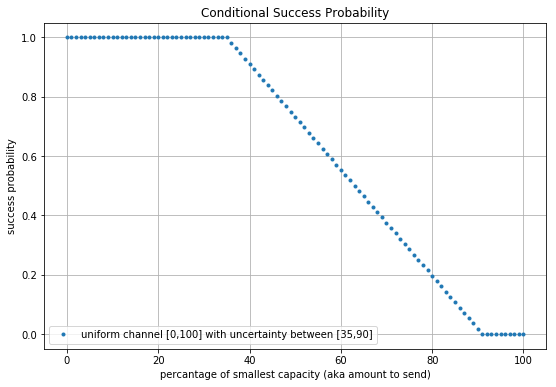

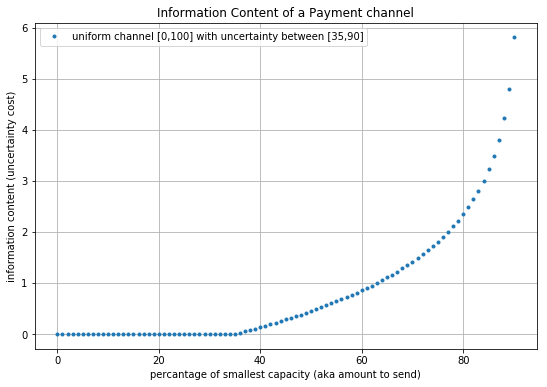

In [4]:
uniform = UniformChannel(100,35,90)
uniform.plot_conditional_success_probability()
uniform.plot_information_content()


## Expected sats to be delivered

More interesting is the amount of satoshis we can expect to deliver on this channel depending on how many sats we allocate in our onion. This expected value is computed as the allocated amount multiplied with the conditional success probability.

The grey area under the curve is the uncertainty interval. We can observe that before the areas is grey the uncertainty raises linearly with the amount. This makes sense because we know for sure that we can send up to the minimum existing liquidity. afterwords the curve will follow the typical shape for a uniform distribution. 

We also look at 2 more channels. One with a min Liquidity of 55 sats and one with full uncertainty. For the one with full uncertainty we see that our intuition to send half the channel size with a success probability of 50% gives us an expected value of 25 sats that will be delivered

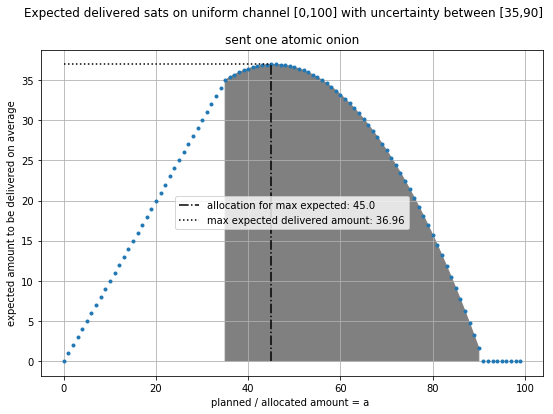

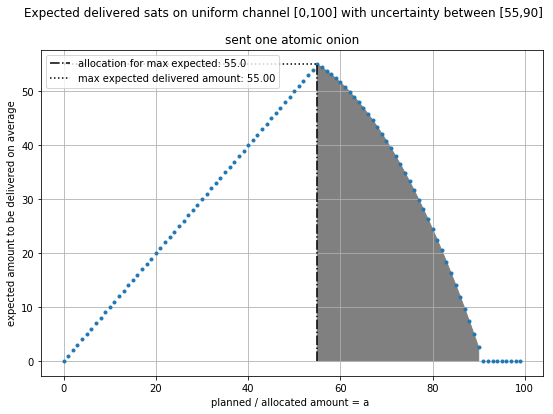

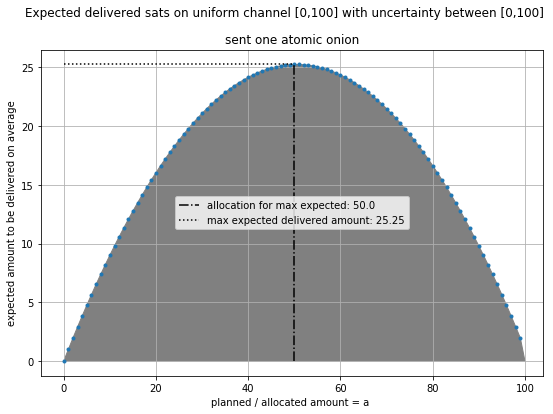

In [5]:
uniform.plot_expected_value_curve()
uniform55 = UniformChannel(100,55,90)
uniform55.plot_expected_value_curve()
uniform_no_knowledge = UniformChannel(100)
uniform_no_knowledge.plot_expected_value_curve()

### Simple splitting heuristic if knowlege about remote channels exist

Looking at the above diagrams we note that in particular if we know that the channel has more than 50% of the capacity our expected value does not raise if we we allocate more sats. This makes sense as the probability even for one additional satoshi drops to heavily. This suggests that a very simple heuristic to increase the expected number of delivered sats is to split the payment into two amounts where the first amount is the number of sats we can savely deliver and the second amount is the the maximum for the uncertainty part of the channel. 

This heuristic should work for any of the channel models. We will depict the first two channels here with the split into two onions. Not that more liquidity will be allocated and we can expect to deliver more liquidity and now also have at least a minimum that we can expect to be delivered. Of course in reality the relies on the assumption that the onion with the certain amount will be forwarded by all nodes before the second onion as we could otherwise have race conditions

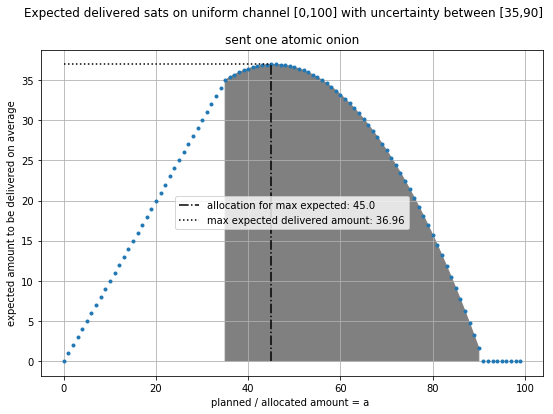

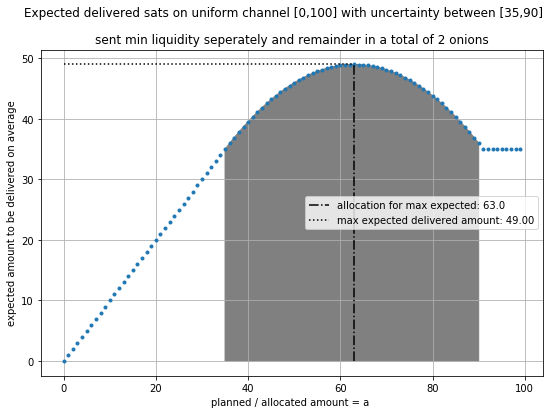

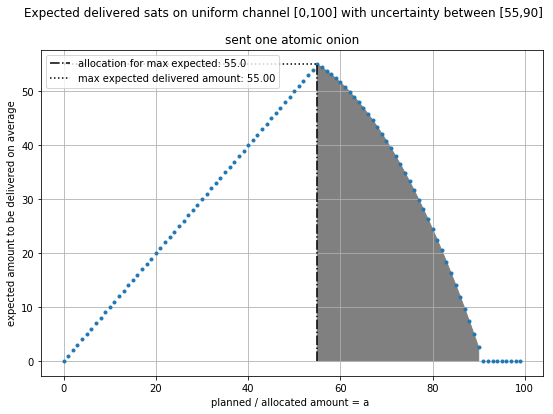

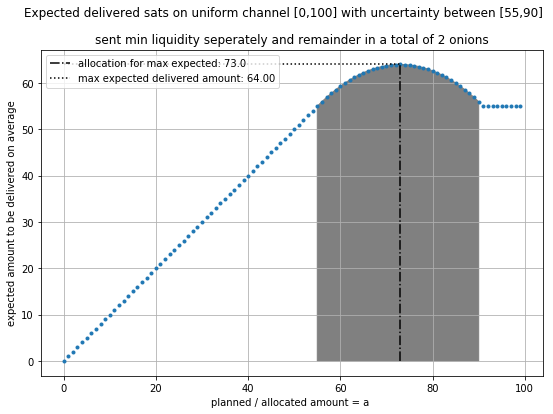

In [6]:
uniform.plot_expected_value_curve()
uniform.plot_expected_value_curve(True)

uniform55.plot_expected_value_curve()
uniform55.plot_expected_value_curve(True)


## 1.2. - Bimodal channel Model 

The biggest criticism of the uniform model is [the fact that on the lightning network one observes drain](https://blog.bitmex.com/the-power-of-htlc_maximum_msat-as-a-control-valve-for-better-flow-control-improved-reliability-and-lower-expected-payment-failure-rates-on-the-lightning-network/). This means that channels are expected to be imbalanced to either one side. As node operators may not know in which direction the drain exist they make a bimodal model assuming the mass of the probability density function has a mode on each end of the channel. While [`lnd` uses two exponential functions to create such a bimodeal model](https://github.com/lightningnetwork/lnd/issues/5988#issuecomment-1131234858) there are ideas by [`ldk` to use a polynom of even order](https://github.com/lightningdevkit/rust-lightning/issues/2276#issuecomment-1540746775). We model the linearized uncertainty cost with the help of a quadratic we thought that we create a bimodal model with the help of a quadratic polynom.

### The Math of the bimodal model: 

$ f(amt) = (amt - 0.5*cap)^2 $ describes a parabola which is cenered around half the channel capacity. Assume we have drain on the channel we can exchange the factor `0.5` with the strength of the drain. In such cases a drain of `0.5` should mean that there is no drain while a drain of `0` or `1` would shift the zero of the polynome to either end of the polynom meaning that the channel is not `bimodal` anymore but `unimodal`. ([See this blogarticle to understand why a drain of `0.5` should not produce a `bimodal` but rather a uniform model](https://blog.bitmex.com/the-power-of-htlc_maximum_msat-as-a-control-valve-for-better-flow-control-improved-reliability-and-lower-expected-payment-failure-rates-on-the-lightning-network/). And note that in the next model (e.g. the `unimodal` model we see how the special case of `0.5` produces the special case of the `uniform` model)

In any case we can produce the `pdf` of the `bimodal` or `quadratic` channel model via the following function.

$pdf(amt) = ((amt - drain*cap)^2 + smmothing)/surface$

Note that the `smoothing` constant is added so that none of the values has `0` probability. In particular one notes that for larger `smoothing` constants the distributions becomes more and more unifom. Again this is in stark contratiction to the fact that a `drain` of `0.5` should make the distribution look uniform. 

In any case we need to normalize the quadratic formula with the surface which we get by computing the integral which luckily corresponds with the `cdf` that we need anyways: 

$cdf(amt) = amt*((drain*cap)^2 + amt*(amt/3-(drain*cap))+smoothing)$ which may be easier to read as

$cdf(a) = a((d*c)^2 + a*(\frac{a}{3} - d*c) + s)$


### Warning 
Obviously the order of the polynom can be changed. One can also use exponentials. However the problems and weaknesses of the bimodal model will be apparent in each of the models. Unless we have strong evidence from mainnet experiments to use a `bimodal` model we strongly suggest to use either a `uniform` or its generalization the `drained channel` model (see below). 

In [7]:
class BimodalQuadraticChannel(Channel):
    def __init__(self,capacity:int, min_liquidity:int =None, max_liquidity:int =None,drain=0.5,smoothing=0):
        super().__init__(capacity, min_liquidity, max_liquidity)
        self.drain=drain
        self.smoothing = smoothing
        
    def __str__(self):
        return "Bimodal "+ super().__str__() + " with {} drain and smoothing of {}".format(self.drain, self.smoothing)
    
    def pdf(self, a):
        surface = self.cdf(self.max_liquidity)-self.cdf(self.min_liquidity)
        if a > self.max_liquidity:
            return 0.0
        #TODO: not clear how to compute pdf for certainty
        if a < self.min_liquidity:
            return 1.0#(self.capacity+1) 
        return ((a-self.drain*self.capacity)**2+self.smoothing)/surface
    
    def cdf(self, a):
        return a*((self.drain*self.capacity)**2 + a*(a/3-(self.drain*self.capacity))+self.smoothing)

Let's look at the `pdf` of a simple channel with full uncertainty and no drain (i.e. a `drain` of `0.5` which is why the `bimodal` model is being invented and studied. We can also add some drain to see how the polynom moves towards one end of the channel. 

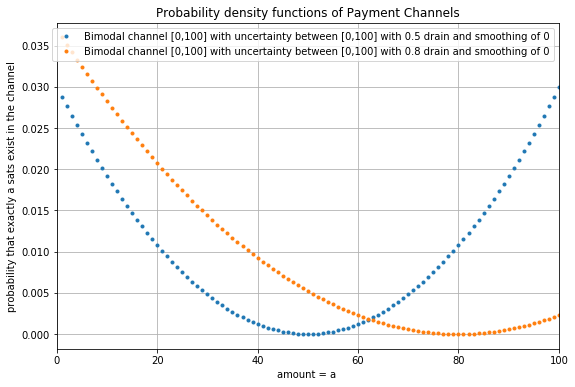

In [8]:
bimodal = BimodalQuadraticChannel(100)
bimodal.plot_pdf(last=False)
bimodal_with_drain = BimodalQuadraticChannel(100,drain=0.8)
bimodal_with_drain.plot_pdf(first=False)


### Weaknesses of the Bimodal Model

Besides the fact that a `drain` of `0.5` does not procude the special case of the `uniform` model the `bimodel` model has several more problems. The first can be seen by looking at the `conditionsl success probabilities` and the `information content` (**which is not convex anymore!**)

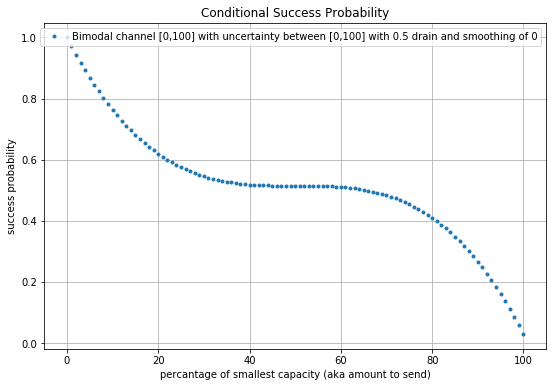

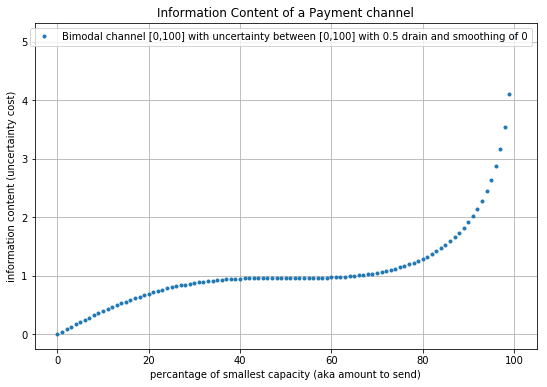

In [9]:
bimodal.plot_conditional_success_probability()
bimodal.plot_information_content()

A bigger problem becomes visible when looking at the expected delivered sats. Due to the fact that a large mass of the probability function is at the end where the peer has all the liquidity and due to the fact that the success probability stays almost constant in a certain range the expected delivered amount seems to grow linearly with the number of sats allocated. This suggests that one should always use almost all the capacity in the channel. Unless experimental results hint that this is a good strategy this approach seems obviously wrong

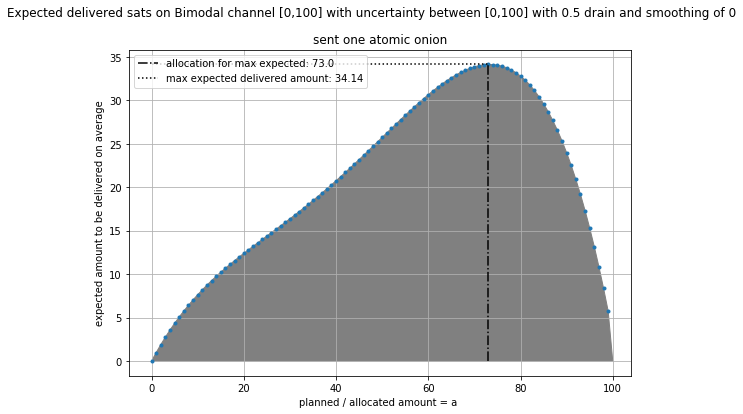

In [10]:
bimodal.plot_expected_value_curve()

### Example with reduced uncertainty and drain

We can see in this example that all of the theory from the `uniform` model can be applied too. However the curve for the expected value get's a really bad shape as one increases the allocated amount quite a bit to statistically deliver just `1.54` sats more instead of sticking with the `20` sats that one already knows. This is another indicator that the `bimodal` model seems to be inacurate. 

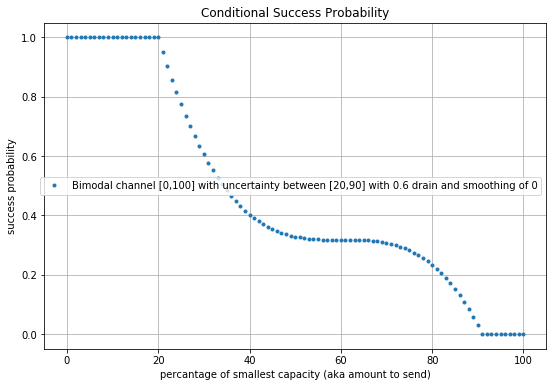

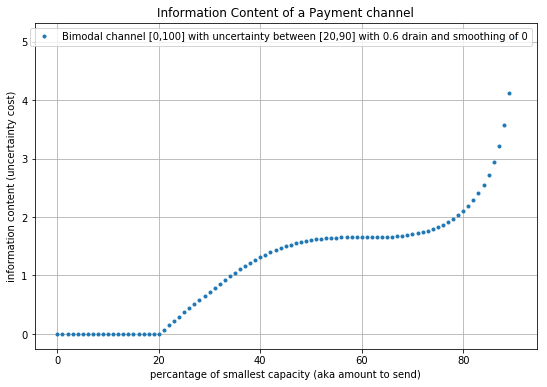

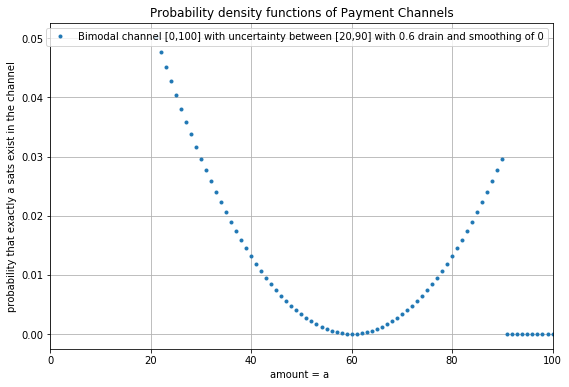

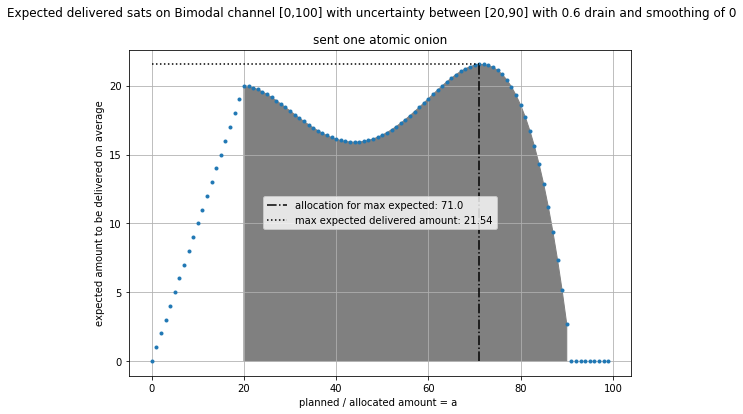

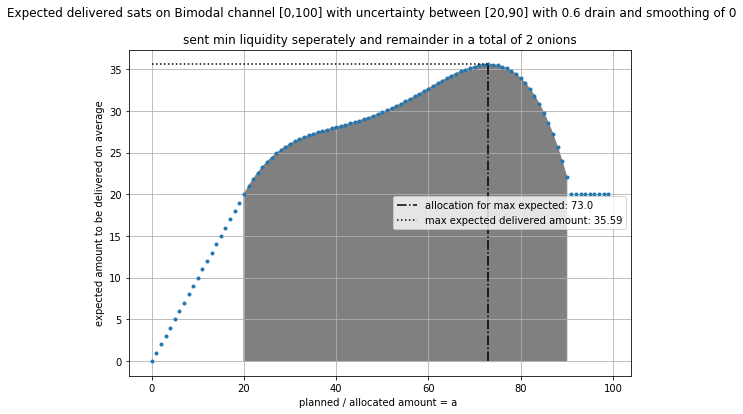

In [11]:
bimodal = BimodalQuadraticChannel(100,20,90,drain=0.6)
bimodal.plot_conditional_success_probability()
bimodal.plot_information_content()
bimodal.plot_pdf()

bimodal.plot_expected_value_curve()
bimodal.plot_expected_value_curve(True)

## 1.3 - The Unimodal / (Linear) Drained Channel Model

As discussed above it seems more reasonable to create a model that boils down to a uniform model for a `drain` of `0.5` and unimodal with the majority of the probability mass on one end of the channel depending on the drain being bigger or smaller than `0.5`. 

The simplest way to achieve this is to have a linear model where the constant `pdf` receives a slope depending on the drain with the edge case that the drain of `0.5` results in the uniform model. This would then be a **proper** `generalization` of the `uniform` model. 

The slope of the `pdf` is defined by: 

$pdf(amt) = \frac{0.5-drain}{cap} * amt + drain*0.5$ (maybe this model is poor as it only allows slopes between -1 and 1)

the constant $drain*0.5$ was chosen so that the curve takes positive values on the interval $[0,cap]$ for all drain values from the interval $[0,1]$

In [12]:
class DrainedChannel(Channel):
    def __init__(self,capacity:int, min_liquidity:int =None, max_liquidity:int =None,drain=0.5):
        super().__init__(capacity, min_liquidity, max_liquidity)
        self.drain=drain
        
    def __str__(self):
        return "Drained "+ super().__str__() + " with drain of {}".format(self.drain)

    def pdf(self,a):
        surface = self.cdf(self.max_liquidity)-self.cdf(self.min_liquidity)
        if a > self.max_liquidity:
            return 0.0
        #TODO: not clear how to compute pdf for certainty
        if a < self.min_liquidity:
            return 1.0 / (self.capacity+1)
        return ((0.5-self.drain)/(self.capacity)*a + self.drain*0.5)/surface

    def cdf(self, a):
        return (0.5-self.drain)/(2*self.capacity)*a**2 + a*self.drain*0.5



Let us first look at a few `pdf`s for various `drain` values. We can see that for a large drain the channel is empty which means that small amounts are more likely to occure than larger values. 

For a lower drain of `0.2` we can assume the channel to be almost full as even higher values become more likely to exists. We also nicely observe that for a drain of `0.5` the `pdf` is constant resmbling the behavior of the `uniform` model. 

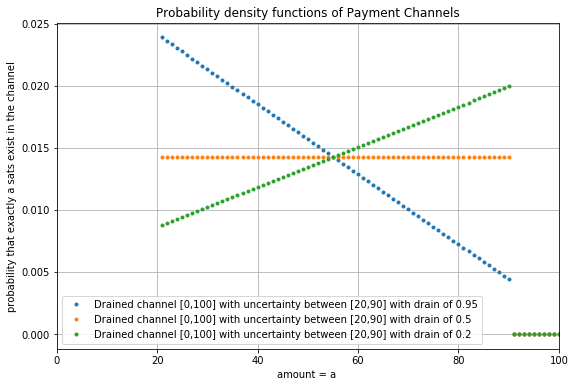

In [13]:
empty = DrainedChannel(100,20,90,drain=0.95)
uni = DrainedChannel(100,20,90,drain=0.5)
full = DrainedChannel(100,20,90,drain=0.2)
empty.plot_pdf(last=False)
uni.plot_pdf(first=False,last=False)
full.plot_pdf(first=False)

We can look at the conditional success probabilties. Since we just have a linear model the shape of the curve in the integral does not change to heavily from the uniform model. (This is indeed the biggest motivation why in the next section we also introduced an exponentially drained model which seems to be more realistic). In any case the Model with drain does already change the success probabilities (and also the `information content`) We note that for drain in both directions the `information` content seems to stay convex. This is particularly nice for `min cost flow` computations.

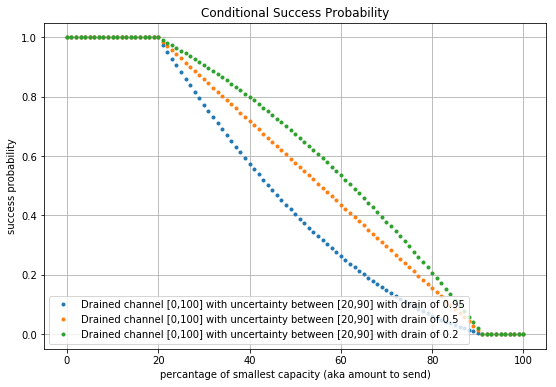

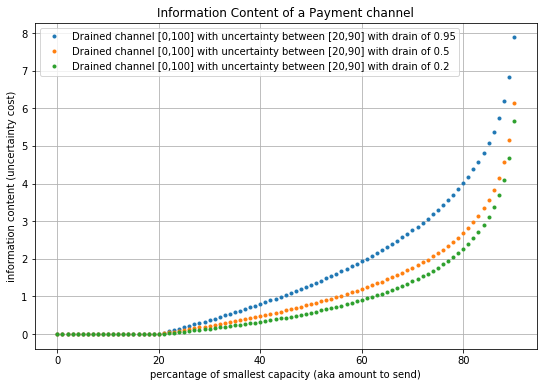

In [14]:
empty.plot_conditional_success_probability(last=False)
uni.plot_conditional_success_probability(first=False,last=False)
full.plot_conditional_success_probability(first=False)

empty.plot_information_content(last=False)
uni.plot_information_content(first=False,last=False)
full.plot_information_content(first=False)

## Expected delivered sats on a drained empty and full channel.

Despite the distributions not seeming to be to far apart from each other we note that for the maximum expected delivered sats we can see quite some difference between the `empty` and the `full` modelled channels. Note that for the `empty` (depleted) channel we allocate more than twice the amount that we expect to deliver and are still only expecting to deliver `15.12` sats. In contrast if we expect the channel to have a low drain and most liquidity on the side of the peer we can expect to deliver `38.31` sats by only overpaying `51%` or sending a total of `58` sats. 

This shows that while the `information content` and `conditional success probabilities` hardly seem to differ from the `uniform` model that this `liear drained channel` model already produces quite some effect. (However it needs to be tested against real world data and we also introduce the exponentially drained model which is inspired by the lnd choice to create a bimodal model from two exponentials)

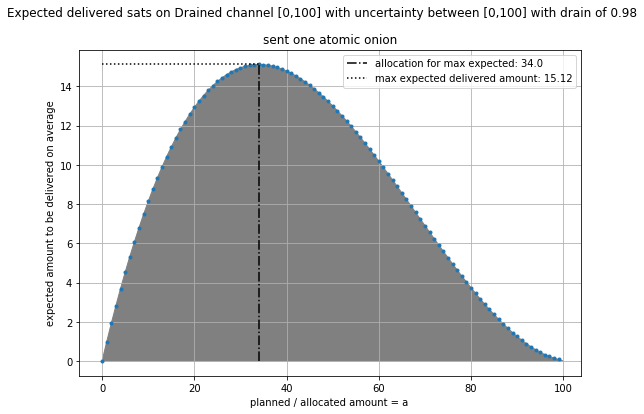

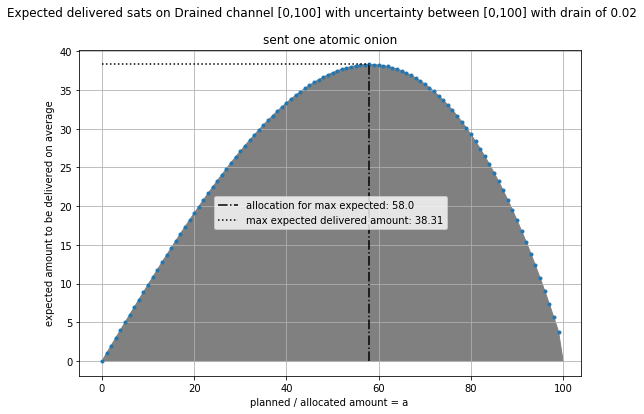

In [15]:
empty = DrainedChannel(100,drain=0.98)
full = DrainedChannel(100,drain=0.02)
empty.plot_expected_value_curve()
full.plot_expected_value_curve()

## 1.4 Exponential Channel Model

The exp model has a stronger drain / skewness in the probability function than the linear drain channel model. The skewness of the exponential model can be controlled with the base of the exponential function. We chose a very moderate base of only `1.2`. Obviously realworld data needs to be used to fit the curve

### Future work

refine the model parameters. here they were chosen arbitrarily to show how the exponential model behaves differently

In [16]:
class ExponentiallyDrainedChannel(Channel):
    def __init__(self,capacity:int, min_liquidity:int =None, max_liquidity:int =None,drain=0.5):
        super().__init__(capacity, min_liquidity, max_liquidity)
        self.drain=drain
        
    def __str__(self):
        return "Exp Drained "+ super().__str__() + " with drain of {}".format(self.drain)

    def pdf(self,a):
        surface = self.cdf(self.max_liquidity)-self.cdf(self.min_liquidity)
        if a > self.max_liquidity:
            return 0.0
        #TODO: not clear how to compute pdf for certainty
        if a < self.min_liquidity:
            return 1.0#(self.capacity+1)
        
        #(0.5 - d) log(b) b^(x (0.5 - d))
        if self.drain == 0.5:
            return 1/(self.max_liquidity - self.min_liquidity + 1)
        return ((0.5 - self.drain)*log(1.2)*self.cdf(a))/(2*surface)# + 1/(self.max_liquidity - self.min_liquidity + 1)

    def cdf(self, a):
        if self.drain==0.5:
            return float(a)/(self.capacity+1)
        return 1.1**((0.5-self.drain)*a)
        #return (0.5-self.drain)/(2*self.capacity)*a**2 + a*self.drain*0.5  
        
        

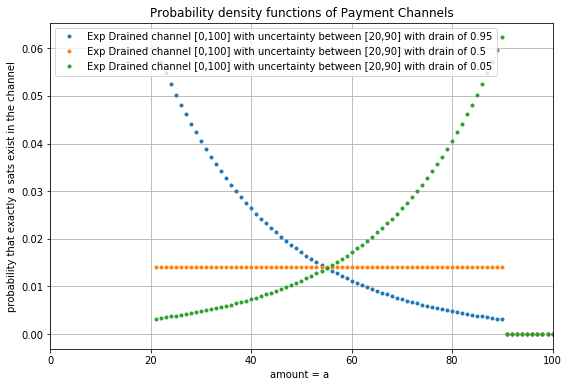

In [17]:
empty = ExponentiallyDrainedChannel(100,20,90,drain=0.95)
uni = ExponentiallyDrainedChannel(100,20,90,drain=0.5)
full = ExponentiallyDrainedChannel(100,20,90,drain=0.05)
empty.plot_pdf(last=False)
uni.plot_pdf(first=False,last=False)
full.plot_pdf(first=False)

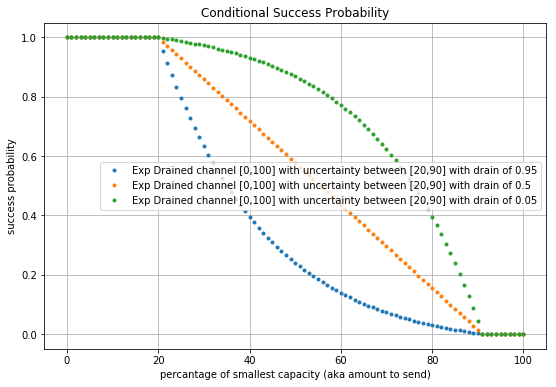

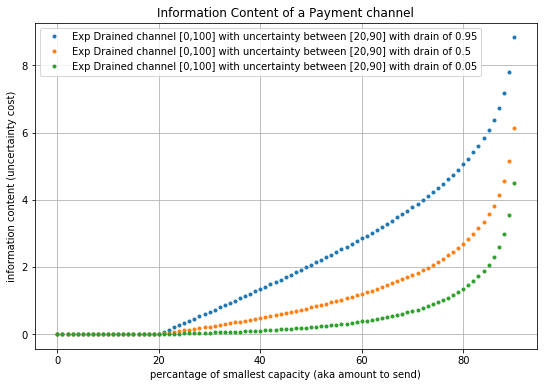

In [18]:
empty.plot_conditional_success_probability(last=False)
uni.plot_conditional_success_probability(first=False,last=False)
full.plot_conditional_success_probability(first=False)

empty.plot_information_content(last=False)
uni.plot_information_content(first=False,last=False)
full.plot_information_content(first=False)

## Stronger Impact on amount to Allocate and expected sats to arrive

We can see that the expected amount to be delivered curve is much more skewed in the exponential model. This makes a lot of sense as we Already from the `pdf` and `cdf` see a much stronger skew. Of course this is no statement about which of these models closer fit the reality. However the intuitions let's one conject that the exponential model (if fittet properly to collected / observed data) should probably be more accurate

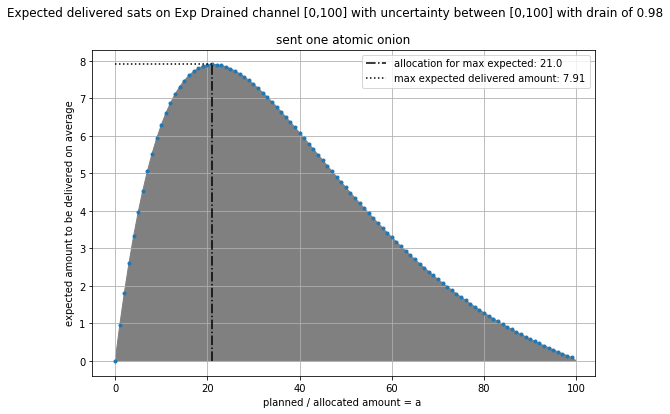

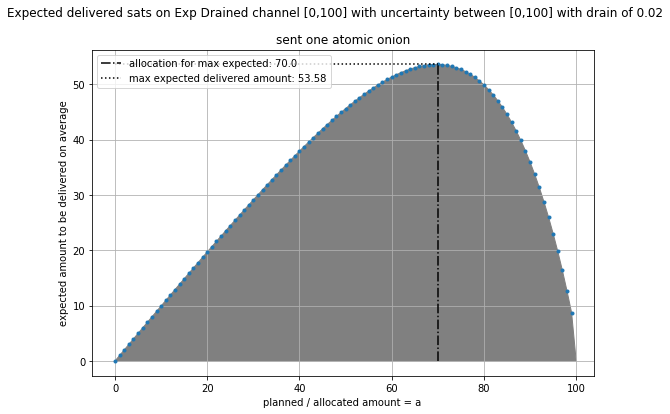

In [130]:
empty = ExponentiallyDrainedChannel(100,drain=0.98)
full = ExponentiallyDrainedChannel(100,drain=0.02)
empty.plot_expected_value_curve()
full.plot_expected_value_curve()

## 1.5 Examples 

following are a few potential API calls that one could make to study how the liquidity distribution, success probabilities and information content of various models behave. One can obvioulsy just skip this section as it is pretty much already contained in the first 4 subssections of this notebook

In [ ]:
a = DrainedChannel(100,20,90,drain=0.9)
b = DrainedChannel(100,20,90,drain=0.1)
a.plot_conditional_success_probability(last=False)
bimodal.plot_conditional_success_probability(first=False,last=False)
b.plot_conditional_success_probability(first=False)

a.plot_information_content(last=False)
bimodal.plot_information_content(first=False,last=False)
b.plot_information_content(first=False)

a.plot_pdf(last=False)
bimodal.plot_pdf(first=False,last=False)
b.plot_pdf(first=False)

bimodal = BimodalQuadraticChannel(100,10,80,0.3,1000)
bimodal.plot_pdf(last=False)
bimodal = BimodalQuadraticChannel(100,10,80,0.3)
bimodal.plot_pdf(first=False,last=False)
bimodal = BimodalQuadraticChannel(100,10,80,0.7)
bimodal.plot_pdf(first=False)

bimodal = BimodalQuadraticChannel(100,10,80,0.3,1000)
bimodal.plot_conditional_success_probability(last=False)
bimodal = BimodalQuadraticChannel(100,10,80,0.3)
bimodal.plot_conditional_success_probability(first=False,last=False)
bimodal = BimodalQuadraticChannel(100,10,80,0.7)
bimodal.plot_conditional_success_probability(first=False)





uniform = UniformChannel(100,10,85)
bimodal = BimodalQuadraticChannel(100,10,85,drain=0.2)
drained = DrainedChannel(100,10,85,drain=0.2)
exp = ExponentiallyDrainedChannel(100,10,85,drain=0.2)

uniform.plot_conditional_success_probability(last=False)
bimodal.plot_conditional_success_probability(first=False,last=False)
drained.plot_conditional_success_probability(first=False,last=False)
exp.plot_conditional_success_probability(first=False)

uniform.plot_pdf(last=False)
bimodal.plot_pdf(first=False,last=False)
drained.plot_pdf(first=False,last=False)
exp.plot_pdf(first=False)





drained = DrainedChannel(100,20,90,drain=0.9)
drained.plot_conditional_success_probability()
drained.plot_pdf()
#path = Path([uniform])
print("interesting: the position of the max does not increase because the payment is atomic! if we split we get a shifted max")
## also clear because max splitting increases expected value but it also means one should alsoways send according to knowledge and plit the uncertain part off...

drained.plot_expected_value_curve()
drained.plot_expected_value_curve(True)

drained = DrainedChannel(100,20,90,drain=0.1)
drained.plot_conditional_success_probability()
drained.plot_pdf()
#path = Path([uniform])
print("interesting: the position of the max does not increase because the payment is atomic! if we split we get a shifted max")
## also clear because max splitting increases expected value but it also means one should alsoways send according to knowledge and plit the uncertain part off...

drained.plot_expected_value_curve()
drained.plot_expected_value_curve(True)



drained = ExponentiallyDrainedChannel(100,20,90,drain=0.9)
drained.plot_conditional_success_probability()
drained.plot_pdf()
#path = Path([uniform])
print("interesting: the position of the max does not increase because the payment is atomic! if we split we get a shifted max")
## also clear because max splitting increases expected value but it also means one should alsoways send according to knowledge and plit the uncertain part off...

drained.plot_expected_value_curve()
drained.plot_expected_value_curve(True)

drained = ExponentiallyDrainedChannel(100,20,90,drain=0.1)
drained.plot_conditional_success_probability()
drained.plot_pdf()
#path = Path([uniform])
print("interesting: the position of the max does not increase because the payment is atomic! if we split we get a shifted max")
## also clear because max splitting increases expected value but it also means one should alsoways send according to knowledge and plit the uncertain part off...

drained.plot_expected_value_curve()
drained.plot_expected_value_curve(True)

# 2 Allocating sats on paths of channels with uncertainty

After we studied 4 different probabilistic models we will now start to investigate how some techniques and algorithms for allocating sats to paths of channels will behave. 

The main idea is to find a maxima of the expected delivered amount for a path of channels which is defined as: 

```
ev(amt) = amt * P_1(X_1 > amt | min_1 < X_1 < max_1) * ... * P_n(X_n > amt | min_n < X_n < max_n)
```

instead of using optimization libraries like scikit learn we use an ad-hoc and runtime inefficient heuristic to find the first local maximum of our function. This is defined in `Path.maximize_expected_value` and is based on a simple exponential binary search idea. In our thousands of diagrams that we plotted the method has always found a sufficiently accurate local maxima but of course in a real world setting one should use a proper optimization library after having trained the model for the uncertainty in channel



# WARNING THE FOLLOWING CODE IS STILL RATHER EXPERIMENTAL AND VERY MUCH WORK IN PROGRESS

In [19]:
class Path():
    def __init__(self, channels: List[Channel]):
        self.channels = channels
      
    def ev(self,amount):
        ev = amount
        for channel in self.channels:
            ev *= channel.conditional_success_probability(amount)
        return ev
    
    def plot_expected_value_curve(self):
        max_ev = 0
        max_amount = 0
        first_max_amount = 0
        first_max_ev = 0 
        found_first_max = False
        expected_values = []
        amounts = []
        #TOD: remove fixed max capacity
        max_cap = min(channel.capacity for channel in self.channels)
        for i in range(100):
            amt = i*max_cap*0.01
            ev = self.ev(amt)
            #print(amt,ev)
            amounts.append(amt)
            expected_values.append(ev)
            if ev > max_ev:
                max_amount = amt
                max_ev = ev
            elif found_first_max==False and i > 0:
                found_first_max = True
                first_max_amount = max_amount
                first_max_ev = max_ev
                
                #probabilities = [channel.pdf(i) for i in range(channel.capacity+1)]
        plt.figure(figsize=(9,6))
        if len(self.channels)>1:
            plt.title("Expected delivered sats on {} channels".format(len(self.channels)))
        else:
            plt.title("Expected delivered sats on " + str(self.channels[0]))
        plt.plot(amounts,expected_values,".")
        #plt.plot(ratio,".")
        plt.plot([max_amount,max_amount],[0,max_ev],"k-.",label="allocation for max expected: {}".format(max_amount))
        plt.plot([0,max_amount],[max_ev,max_ev],"k:",label="max expected delivered amount: {:4.2f}".format(max_ev))

        if first_max_ev != max_ev:
            plt.plot([first_max_amount,first_max_amount],[0,first_max_ev],"r-.",label="allocation for first max expected: {}".format(first_max_amount))
            plt.plot([0,first_max_amount],[first_max_ev,first_max_ev],"r:",label="first max expected delivered amount: {:4.2f}".format(first_max_ev))

        
        plt.xlabel("planned / allocated amount = a ")
        plt.ylabel("expected amount to be delivered on average")
        #plt.ylim(0,25)
        plt.legend()
        plt.grid()
        plt.show()
        #return expected_values, max_amount, max_ev    
        
    def maximize_expected_value(self):
        """
        A method to find a local maxima of the expected value curve
        """
        left = min(c.min_liquidity for c in self.channels)
        right = max(c.max_liquidity for c in self.channels)
        window = right-left
        cnt = 0
        while (right - left)*5000 > window:
            cnt +=1
            #print("ROUND ",cnt)
            points = int(log(right-left))
            max_ev = 0
            max_amt = 0
            start = left
            for i in range(points):
                amount = start + 2**i
                ev = self.ev(amount)
                #print(amount, ev)
                if ev > max_ev:
                    max_ev = ev
                    max_amt = amount
                    left = start + 2**(i-1)
                else:
                    right = amount
                    break
            if cnt ==50:
                print("reached 50 iterations")
        #print(max_ev, max_amt, left, right)
        return max_ev,max_amt
        
        #print("test {} points".format(points))
#        print(search in right)

In [20]:
import json
import networkx as nx

We quickly parse a Lightning Network channel graph to Network X. Our method of parsing combines parallel channels into the last chanel update that we see in our data set. 

In an opionionated ad'hoc way we estimate the drain of the channel as one minus the fraction of PPM in the direction of the channel with the total PPM of the channel in both directions. 

This means if we have a high ppm in one direction the fraction will be close to `1` and the drain thus close to `0`. As we saw before drains close to `0` are the ones were we expect to have a lot of liquidity on our end. We multiply the drain with the linearized uncertainty cost which is `1/cap` and thus have a cost for path finding that is based on prefering paths with low drain and low uncertainty. In particular this model will be impractical as it ignores the routing fees. However one could envision a multiplication of the fees to the cost to also account for those. In practise one will probably wish to have a different estimation for the drain anyway. In our case this is just to somehow show how the paths will be allocated with sats and how a redundant overpayment is being planned

In [21]:
f=open("listchannels20220412.json")
channels = json.load(f)["channels"]
tmpG = nx.DiGraph()
RENE = "03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df"
C_OTTO = "027ce055380348d7812d2ae7745701c9f93e70c1adeb2657f053f91df4f2843c71"
for channel in channels:
    cap = int(channel["satoshis"])
    src = channel["source"]
    dest = channel["destination"]
    ppm = int(channel["fee_per_millionth"])+1
    tmpG.add_edge(src,dest,ppm=ppm,cap=cap)
    
G = nx.DiGraph()
drains = []
for src,dest in tmpG.edges():
    if tmpG.has_edge(dest,src):
        drain = 1-float(tmpG[src][dest]["ppm"])/(tmpG[src][dest]["ppm"]+tmpG[dest][src]["ppm"]+0.01)
        drains.append(drain)
        cap = tmpG[src][dest]["cap"]
        a = UniformChannel(cap)#),drain=drain)
        G.add_edge(src,dest,weight = (1-drain)/cap,channel=a)


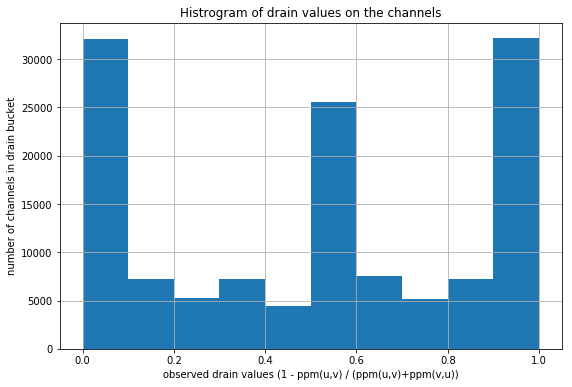

In [22]:
plt.figure(figsize=(9,6))
plt.title("Histrogram of drain values on the channels")
plt.hist(drains)
plt.grid()
plt.xlabel("observed drain values (1 - ppm(u,v) / (ppm(u,v)+ppm(v,u))")
plt.ylabel("number of channels in drain bucket")
plt.show()

In [23]:
def next_hop(path):
    """
    generator to iterate through edges indexed by node id of paths

    The path is a list of node ids. Each call returns a tuple src, dest of an edge in the path
    """
    for i in range(1, len(path)):
        src = path[i - 1]
        dest = path[i]
        yield src, dest

## 2.2 The actual allocation algorithm

* We find shortest paths according to the above defined cost function. 
* For each path we allocate as many sats as it maximizes the expected value curve
* we then readjust the cost of the channels as they shrinked in size and the uncertainty changed. 
* We rinse and repeat until the total expected value meats the amount we wished to deliver

In [24]:
amount = 20_000_000
start = time.time()
total_ev = 0
amounts = []
evs = []
cnt = 0

overpayment_percentages = []

while total_ev < amount:
    path = nx.shortest_path(G,RENE,C_OTTO,weight="weight")
    tmp = [G[src][dest]["channel"] for src, dest in next_hop(path)]
    #for c in tmp:
    #    print(c)
    #print()
    p = Path(tmp)
    #print(path)
    #p.plot_expected_value_curve()
    ev, amt = p.maximize_expected_value()
    print("allocated {:10} sats to expect to deliver {:10.0f} sats via {:2} channels. Overpayment by {:4.2f}%.".format(
        amt,
        ev,
        len(tmp),
        (amt/ev-1)*100)
         )
    overpayment_percentages.append((amt/ev-1)*100)
    total_ev += ev
    amounts.append(amt)
    evs.append(int(ev))
    if total_ev > amount:
        break
    for src, dest in next_hop(path):
        c = G[src][dest]["channel"].capacity
        G[src][dest]["channel"].capacity = c - amt
        G[src][dest]["channel"].max_liquidity = c - amt
        G[src][dest]["weight"] = G[src][dest]["weight"]*c/(c-amt)
    cnt += 1
    if cnt > 100:
        print("Stopped as we needed too many rounds of allocations")
        break

print("============")
print("allocated a total of {} sats to expect to deliver {} via {} paths".format(sum(amounts), sum(evs), len(amounts)))
print("this is an overpayment of {:5.2f}%".format((sum(amounts)/sum(evs)-1)*100))
end = time.time()


print("Computation took: {:4.2f} seconds".format(end-start))


allocated      65536 sats to expect to deliver      22403 sats via  5 channels. Overpayment by 192.54%.
allocated      16384 sats to expect to deliver       8578 sats via  5 channels. Overpayment by 91.01%.
allocated    2634752 sats to expect to deliver    1071081 sats via  5 channels. Overpayment by 145.99%.
allocated    2118656 sats to expect to deliver     867070 sats via  5 channels. Overpayment by 144.35%.
allocated     487424 sats to expect to deliver     239639 sats via  5 channels. Overpayment by 103.40%.
allocated     462848 sats to expect to deliver     206412 sats via  5 channels. Overpayment by 124.24%.
allocated     245760 sats to expect to deliver     125219 sats via  5 channels. Overpayment by 96.26%.
allocated     131072 sats to expect to deliver      65920 sats via  5 channels. Overpayment by 98.83%.
allocated    1667072 sats to expect to deliver     689696 sats via  5 channels. Overpayment by 141.71%.
allocated    1384448 sats to expect to deliver     578977 sats via 

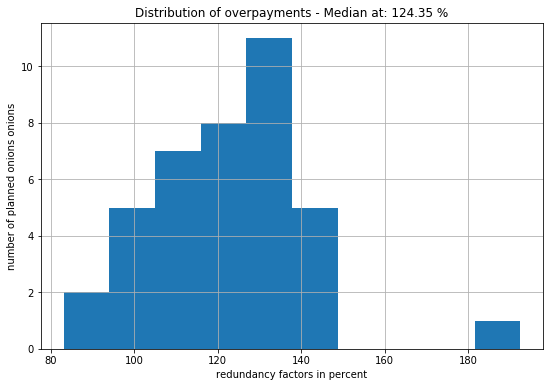

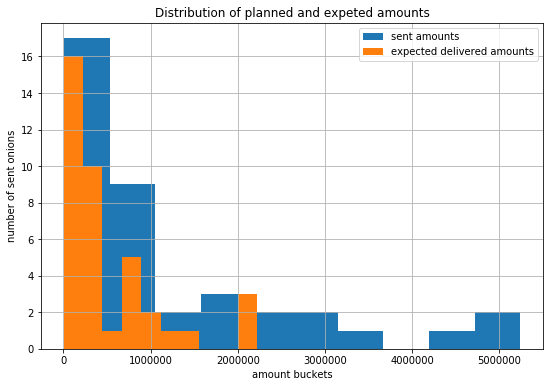

In [25]:
plt.figure(figsize=(9,6))
plt.title("Distribution of overpayments - Median at: {:4.2f} %".format(np.median(overpayment_percentages)))
plt.hist(overpayment_percentages)
plt.grid()
plt.xlabel("redundancy factors in percent")
plt.ylabel("number of planned onions onions")
plt.show()

plt.figure(figsize=(9,6))
plt.title("Distribution of planned and expeted amounts")
plt.hist(amounts,label="sent amounts")
plt.hist(evs,label="expected delivered amounts")
plt.grid()
plt.legend()
plt.xlabel("amount buckets")
plt.ylabel("number of sent onions")
plt.show()

# Code leftovers and open ends
# IGNORE FROM HERE
# Probably remote later for cleanup

In [ ]:
p.maximize_expected_value()
p.plot_expected_value_curve()
a = DrainedChannel(100,0,100,0.4)
#a.plot_conditional_success_probability()
b = DrainedChannel(100,15,100,0.65)
#b.plot_conditional_success_probability()

a.plot_conditional_success_probability()
a.plot_pdf()
b.plot_pdf()

print(a)
print(b)
p = Path([a,b])
p.plot_expected_value_curve()

a = ExponentiallyDrainedChannel(100,5,95,0.99)
#a.plot_conditional_success_probability()
b = ExponentiallyDrainedChannel(100,0,100,0.01)
#b.plot_conditional_success_probability()
a.plot_pdf()
b.plot_pdf()

print(a)
print(b)
p = Path([a,b])
p.plot_expected_value_curve()

a = DrainedChannel(20000000,0,20000000,0.95)
b = DrainedChannel(10000000,0,10000000,0.95)
c = DrainedChannel(50000000,0,50000000,0.95)
d = DrainedChannel(1000000,0,1000000,0.95)
#a.plot_conditional_success_probability()
#d.plot_conditional_success_probability()
#print(a)
#print(b)
#p = Path([a,b,c,d])
#p.plot_expected_value_curve()

p = Path([a,b,c,d])
start = time.time()
p.maximize_expected_value()
end = time.time()
print(end-start)
p.plot_expected_value_curve()


In [ ]:
c = DrainedChannel(1_000_000,50_000,800_000,0.1)
c.conditional_success_probability(100_000)

uni = UniformChannel(100,20)
bi = BimodalQuadraticChannel(100,0,80)
print(uni)
print(bi)
p = Path([uni,bi])
p.plot_expected_value_curve()


a = UniformChannel(100)
b = UniformChannel(100)
print(a)
print(b)
p = Path([a,b])
p.plot_expected_value_curve()


a = BimodalQuadraticChannel(100,drain=0.6)
b = BimodalQuadraticChannel(100,drain=0.55)
print(a)
print(b)
p = Path([a,b])
p.plot_expected_value_curve()



## OK HOW TO CHOOSE ALLOCATION?!
"""
* Option1: maximum expected value
* option2: best factor (abovethreshold)
* option3: first maximum as we want to keep the allocation low
"""


bi.plot_conditional_success_probability()
bi.plot_pdf()

uni.plot_pdf()
uni.plot_conditional_success_probability()


## Linearization and quadratic cost function

In [ ]:
CAPACITY = 100
def uncertainty_cost_uniform(amount,capacity):
    return -log(1-amount/(capacity+1))
costs = [uncertainty_cost_uniform(i,CAPACITY) for i in range(CAPACITY+1)]

plt.plot(costs)
plt.plot([0,100],[log(CAPACITY+1),log(CAPACITY+1)],"k-.")
plt.xlabel("amount")
plt.ylabel("uncertainty cost")
plt.grid()
plt.show()

In [ ]:
CAPACITY = 100

def integral(a,c,b):
    return a*(c**2 + a*(a/3-c)+b)

def quadratic_probability_with_drain(a,c,d,b=0,min_liq=0, max_liq=None):
    if max_liq is None:
        max_liq = c
    surface = integral(max_liq,c*d,b)-integral(min_liq,c*d,b)
    if a > max_liq:
        return 0
    if a <= min_liq:
        return 0 
    return ((a-c*d)**2+b)/surface

def quadratic_cdf(c,d=0.5,b=0,min_liq=0, max_liq=None):
    costs = [quadratic_probability_with_drain(amt,c,d,b,min_liq=min_liq, max_liq=max_liq) for amt in range(c+1)]
    tmp = 1 - np.cumsum(costs)
    t = tmp[-1]
    if t < 0:
        t = 0
    return [max(a-t,0) for a in tmp]

def conditional_probability(a,min_liquidity, max_liquidity, cdf):
    high = cdf[max_liquidity]
    low = cdf[min_liquidity]
    if a < min_liquidity:
        return 1
    if a > max_liquidity:
        return 0
    return cdf[a]/low

costs = quadratic_cdf(CAPACITY,0.05,100,min_liq = 0, max_liq = CAPACITY)
costs2 = quadratic_cdf(CAPACITY,0.25,1000,min_liq = 0, max_liq = CAPACITY/2)

costs3 = [i*costs[i]*costs2[i]*costs[i] for i in range(CAPACITY+1)]
#costs2 = [conditional_probability(amt, 10, 40, costs) for amt in range(CAPACITY +1)]
#costs = [quadratic_probability_with_drain(i,CAPACITY,0.75,1500,min_liq = 10, max_liq = 40) for i in range(CAPACITY+1)]
#costs = [i*quadratic_probability_with_drain(i,CAPACITY,0.5)*quadratic_probability_with_drain(i,CAPACITY,0.5) for i in range(CAPACITY+1)]
plt.plot(costs)
plt.plot(costs2)
plt.plot(costs3)
#plt.plot([0,100],[log(CAPACITY+1),log(CAPACITY+1)],"k-.")
#plt.ylim(0,max(costs))
plt.grid()
plt.show()

# Expected value per path

In [ ]:
costs = [i*uniform_probability(i,CAPACITY)**2 for i in range(CAPACITY+1)]

plt.plot(costs)
#costs = [f(i) for i in range(CAPACITY+1)]
#plt.plot(costs)
#plt.plot([0,100],[log(CAPACITY+1),log(CAPACITY+1)],"k-.")
plt.grid()
plt.show()

## Uniform Case

In [ ]:
def uni_prob(a,c):
    return 1.0/(c+1)

def uni_integral(a,c):
    return float(a)/(c+1)

def uni_successprob(a,c,min_liquidity=None,max_liquidity=None):
    if min_liquidity is None:
        min_liquidity = 0
    if max_liquidity is None:
        max_liquidity = c
    if a <= min_liquidity:
        return 1
    if a > max_liquidity:
        return 0
    conditional_amt = a - min_liquidity
    conditional_capacity = max_liquidity - min_liquidity
    
    return uni_integral(conditional_capacity+1,conditional_capacity) - uni_integral(conditional_amt,conditional_capacity)

def uni_successprob2(a,c,min_liquidity=None,max_liquidity=None):
    if min_liquidity is None:
        min_liquidity = 0
    if max_liquidity is None:
        max_liquidity = c
    if a <= min_liquidity:
        return 1
    if a > max_liquidity:
        return 0
    
    numerator = uni_integral(max_liquidity,c) - uni_integral(a,c)
    denumerator = uni_integral(max_liquidity,c) - uni_integral(min_liquidity,c)
    return numerator/denumerator    

def success_prob(amount, capacity, min_liquidity=None, max_liquidity=None):
    if min_liquidity is None:
        min_liquidity = 0
    if max_liquidity is None:
        max_liquidity = capacity
    return uni_successprob2(int(amount*100.)/capacity, 100, int(min_liquidity*100./capacity),int(max_liquidity*100./capacity))

## Bimodal / Quadratic case

In [ ]:
def integral(a,c,b):
    return a*(c**2 + a*(a/3-c)+b)

def quadratic_probability_with_drain(a,c,d,b=0,min_liq=0, max_liq=None):
    if max_liq is None:
        max_liq = c
    surface = integral(max_liq,c*d,b)-integral(min_liq,c*d,b)
    if a > max_liq:
        return 0
    if a <= min_liq:
        return 0 
    return ((a-c*d)**2+b)/surface

def bimodal_integral(a,c):
    return integral(a,c/2,c/2)/integral(c,c/2,c/2)

def bimodal_successprob(a,c,min_liquidity=None,max_liquidity=None):
    if min_liquidity is None:
        min_liquidity = 0
    if max_liquidity is None:
        max_liquidity = c
    if a <= min_liquidity:
        return 1
    if a > max_liquidity:
        return 0
    
    numerator = bimodal_integral(max_liquidity,c) - bimodal_integral(a,c)
    denumerator = bimodal_integral(max_liquidity,c) - bimodal_integral(min_liquidity,c)
    return numerator/denumerator    

def bimodal_success_prob(amount, capacity, min_liquidity=None, max_liquidity=None):
    if min_liquidity is None:
        min_liquidity = 0
    if max_liquidity is None:
        max_liquidity = capacity
    return bimodal_successprob(int(amount*100.)/capacity, 100, int(min_liquidity*100./capacity),int(max_liquidity*100./capacity))

    

In [ ]:

vals = [bimodal_successprob2(i,100,20,90) for i in range(101)]
plot(vals)

vals = [bimodal_integral(i,100) for i in range(101)]
plot(vals)
vals = [uni_integral(i,100) for i in range(101)]
plot(vals)


a = 50
for c in channel_capacities:
    print(success_prob(a,c), 1-a/(c+1))
N = 100

def expected_value(channel_capacities,model="uni"):
    max_ev = 0
    max_amount = 0
    stepsize = (1.0*min(channel_capacities))/N
    expected_values = []
    for i in range(N):
        ev = i*stepsize
        for c in channel_capacities:
            #print(i,i*stepsize,c,success_prob(i*stepsize,c))
            if model == "uni":
                ev *= success_prob(i*stepsize,c)
            elif model == "bimodal":
                ev *= bimodal_successprob(i*stepsize,c)
            else:
                raise Exception("unknown Model")
        expected_values.append(ev)
        if ev > max_ev:
            max_amount = i*stepsize
            max_ev = ev
    return expected_values, max_amount, max_ev

#print(ev)

channel_capacities = [100,100]#,300,80]

ev,amount,expected_delivery = expected_value(channel_capacities,model="bimodal")
print(amount, expected_delivery)


p2 = [uni_successprob(a,100,10,55) for a in range(101)]
p3 = [uni_successprob2(a,100,10,55) for a in range(101)]

def plot(probabilities):
    plt.plot(probabilities)
    plt.xlabel("percantage of smallest capacity (aka amount to send)")
    plt.ylabel("success probability")
    plt.grid()
    plt.show()

#plot(p2)
#plot(p3)
plot(ev)

Observation: 

Maximizing the expected value may not be usful as it locks up way too much liquidity. 

instead one could seach for points where the second derrivative is 0 (instead of maximum which is first derrivative. Second derrivative is "Wendepunkt"

## Uni modal / skewed distribution

this model has just one linear mode (the PDF would be a line with positive or negative slope depending on the drain and the integral would be a quadratic

In [ ]:
def skew_prob(a,c):
    return a/(2*c**2)

def skew_integral(a,c):
    return float(a**2)/(c**2)

def skew_successprob(a,c,min_liquidity=None,max_liquidity=None):
    if min_liquidity is None:
        min_liquidity = 0
    if max_liquidity is None:
        max_liquidity = c
    if a <= min_liquidity:
        return 1
    if a > max_liquidity:
        return 0
    
    numerator = skew_integral(max_liquidity,c) - skew_integral(a,c)
    denumerator = skew_integral(max_liquidity,c) - skew_integral(min_liquidity,c)
    return numerator/denumerator    

vals = [skew_prob(i,100) for i in range(101)]
plot(vals)

vals = [skew_successprob(i,100,5,98) for i in range(101)]
plot(vals)

vals = [skew_integral(i,100) for i in range(101)]
plot(vals)

vals = [i*skew_successprob(i,100)*skew_successprob(i,100)**5*skew_successprob(i,100)*skew_successprob(i,100) for i in range(101)]
plot(vals)

def pdf(a,c,d=0.5):
    return (0.5-d)*a/c + d/2

def integral(a,c,d=1):
    return 2**((0.5-d)*a)
    #return (0.5-d)/(2*c)*a**2 + a*d*0.5